# Phân tích cảm xúc dựa trên đánh giá - Nhóm 5

### 

Kiểm tra và sử dụng GPU

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

CUDA available: False
GPU name: None


Nạp datasets

In [2]:
from datasets import load_dataset

dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

/Users/n0x/anaconda3/envs/imdb-sentiment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset imdb downloaded and prepared to /Users/n0x/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


100%|██████████| 3/3 [00:00<00:00, 519.83it/s]


In [ ]:
import re
import html
import emoji

def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r'<.*?>', '', text)
    text = emoji.replace_emoji(text, replace='[EMOJI]')
    text = re.sub(r'[^\w\s.,!?\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_dataset(dataset):
    return dataset.map(lambda x: {'text': clean_text(x['text'])})

train_data = clean_dataset(train_data)
test_data = clean_dataset(test_data)

Biểu đồ 

/var/folders/yv/6tdt9lfx38zcpy58fwk_l64r0000gp/T/ipykernel_69931/2588101566.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


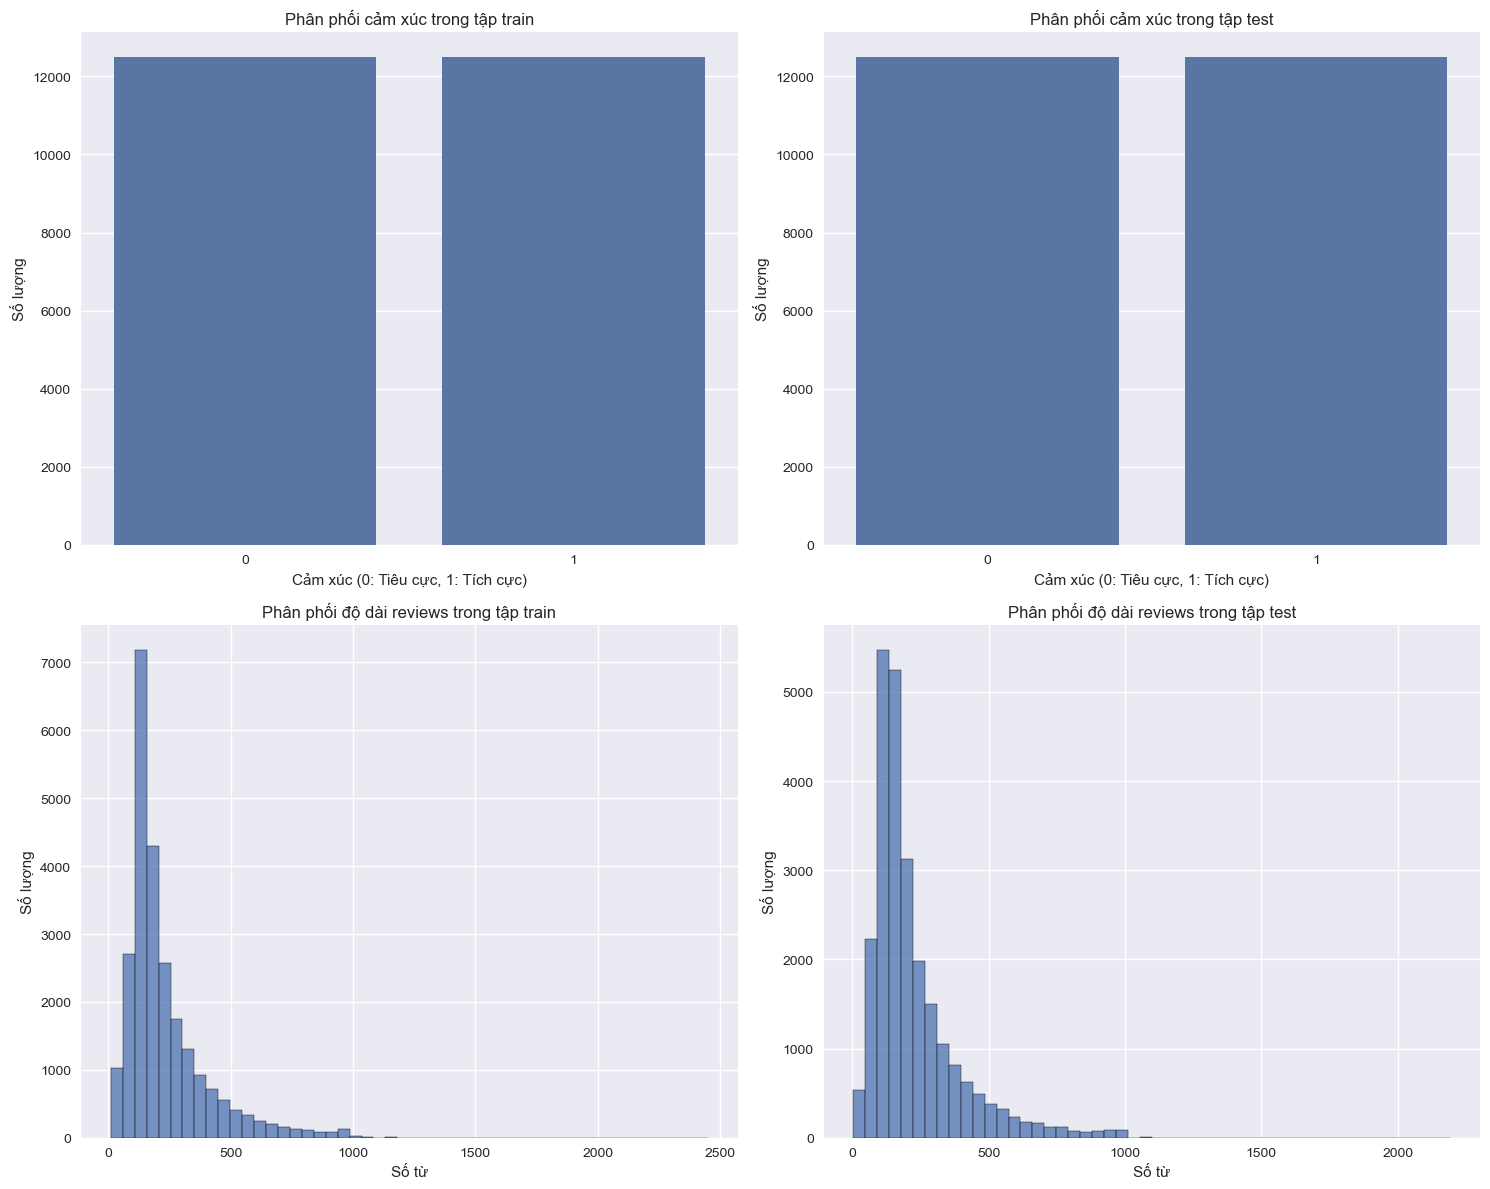


Thống kê cơ bản về độ dài reviews:
Tập train - Trung bình: 229.40 từ, Tối đa: 2450 từ
Tập test - Trung bình: 224.23 từ, Tối đa: 2192 từ

Phân phối cảm xúc:
Tập train - Tiêu cực: 12500, Tích cực: 12500
Tập test - Tiêu cực: 12500, Tích cực: 12500


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn')

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

train_labels = [item['label'] for item in train_data]
test_labels = [item['label'] for item in test_data]

sns.countplot(x=train_labels, ax=axes[0, 0])
axes[0, 0].set_title('Phân phối cảm xúc trong tập train')
axes[0, 0].set_xlabel('Cảm xúc (0: Tiêu cực, 1: Tích cực)')
axes[0, 0].set_ylabel('Số lượng')

sns.countplot(x=test_labels, ax=axes[0, 1])
axes[0, 1].set_title('Phân phối cảm xúc trong tập test')
axes[0, 1].set_xlabel('Cảm xúc (0: Tiêu cực, 1: Tích cực)')
axes[0, 1].set_ylabel('Số lượng')

train_lengths = [len(item['text'].split()) for item in train_data]
test_lengths = [len(item['text'].split()) for item in test_data]

sns.histplot(train_lengths, bins=50, ax=axes[1, 0])
axes[1, 0].set_title('Phân phối độ dài reviews trong tập train')
axes[1, 0].set_xlabel('Số từ')
axes[1, 0].set_ylabel('Số lượng')

sns.histplot(test_lengths, bins=50, ax=axes[1, 1])
axes[1, 1].set_title('Phân phối độ dài reviews trong tập test')
axes[1, 1].set_xlabel('Số từ')
axes[1, 1].set_ylabel('Số lượng')

plt.tight_layout()
plt.show()

print("\nThống kê cơ bản về độ dài reviews:")
print(f"Tập train - Trung bình: {np.mean(train_lengths):.2f} từ, Tối đa: {max(train_lengths)} từ")
print(f"Tập test - Trung bình: {np.mean(test_lengths):.2f} từ, Tối đa: {max(test_lengths)} từ")

print("\nPhân phối cảm xúc:")
print(f"Tập train - Tiêu cực: {train_labels.count(0)}, Tích cực: {train_labels.count(1)}")
print(f"Tập test - Tiêu cực: {test_labels.count(0)}, Tích cực: {test_labels.count(1)}")

Làm sạch dữ liệu, bao gồm xoá các tag html, loại bỏ các ký tự chứa icon cảm xúc

In [14]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("imdb-finetuned")
tokenizer = BertTokenizer.from_pretrained("imdb-finetuned")
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Đọc review từ file 

In [15]:
review = input("Nhập review: ").strip()

Tokenize các chuỗi review

In [16]:
inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

Dùng mô hình đã train, dự đoán cảm xúc

In [17]:
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

In kết quả

In [18]:
sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Review sentiment: {sentiment}")

Review sentiment: Positive
